# APPLIED DATA SCIENCE CAPSTONE PROJECT

## STUDY OF NEIGHBORHOODS ON INDIA FOR A NEW SPANISH RESTAURANT 

In [1]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 9.4 MB/s  eta 0:00:01
/opt/conda/envs/Python-3.7-main/

### DATA SOURCE

In [84]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai')[-1]
df.rename(columns={'Area': 'Neighborhood'}, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
5,Marol,"Andheri,Western Suburbs",19.119219,72.882743
6,Sahar,"Andheri,Western Suburbs",19.098889,72.867222
7,Seven Bungalows,"Andheri,Western Suburbs",19.129052,72.817018
8,Versova,"Andheri,Western Suburbs",19.120000,72.820000
9,Mira Road,"Mira-Bhayandar,Western Suburbs",19.284167,72.871111


### DATA WRANGLING

In [85]:
df['Location'].value_counts()

South Mumbai                       30
Andheri,Western Suburbs             8
Western Suburbs                     6
Eastern Suburbs                     4
Ghatkopar,Eastern Suburbs           3
Kandivali West,Western Suburbs      3
Powai,Eastern Suburbs               3
Mira-Bhayandar,Western Suburbs      3
Bandra,Western Suburbs              3
Vasai,Western Suburbs               2
Kalbadevi,South Mumbai              2
Goregaon,Western Suburbs            2
Malad,Western Suburbs               2
Borivali (West),Western Suburbs     2
Harbour Suburbs                     2
Mumbai                              2
Khar,Western Suburbs                2
Vile Parle,Western Suburbs          1
Kurla,Eastern Suburbs               1
Colaba,South Mumbai                 1
Kandivali East,Western Suburbs      1
Kamathipura,South Mumbai            1
Antop Hill,South Mumbai             1
Mulund,Eastern Suburbs              1
Sanctacruz,Western Suburbs          1
Dadar,South Mumbai                  1
Fort,South M

### CLEANING

In [12]:
df['Location'] = df['Location'].apply(lambda x: x.split(',')[-1])
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270
5,Marol,Western Suburbs,19.119219,72.882743
6,Sahar,Western Suburbs,19.098889,72.867222
7,Seven Bungalows,Western Suburbs,19.129052,72.817018
8,Versova,Western Suburbs,19.120000,72.820000
9,Mira Road,Western Suburbs,19.284167,72.871111


In [13]:
df['Location'].value_counts()

South Mumbai       39
Western Suburbs    36
Eastern Suburbs    12
Harbour Suburbs     4
Mumbai              2
Name: Location, dtype: int64

In [20]:
df

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.129300,72.843400,19.1291,72.8464,0.00024,0.00304
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.124714,72.827210,19.1264,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.130815,72.829270,19.1432,72.8249,0.012345,0.0044
...,...,...,...,...,...,...,...,...
88,Parel,South Mumbai,18.990000,72.840000,None,None,0.0057,0.00087
89,Gowalia Tank,South Mumbai,18.962450,72.809703,None,None,0.00201,0.001467
90,Dava Bazaar,South Mumbai,18.946882,72.831362,None,None,0.184518,0.095598
91,Dharavi,Mumbai,19.040208,72.850850,None,None,0.006532,0.00376


### DATA WITH GEOCODER

In [29]:
for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Mumbai, India'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude1'] = latitude
    df.loc[i, 'Longitude1'] = longitude

df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249
5,Marol,Western Suburbs,19.1192,72.8827,19.1191,72.8828
6,Sahar,Western Suburbs,19.1027,72.8626,19.1027,72.8626
7,Seven Bungalows,Western Suburbs,19.1291,72.8212,19.1286,72.8212
8,Versova,Western Suburbs,19.1377,72.8135,19.1377,72.8135
9,Mira Road,Western Suburbs,19.2656,72.8711,19.2656,72.8706


In [30]:
df['Latdiff'] = abs(df['Latitude'] - df['Latitude1'])
df['Longdiff'] = abs(df['Longitude'] - df['Longitude1'])
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464,0.00024,0
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0,0
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325,0.000965,0
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0,0
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0,0
5,Marol,Western Suburbs,19.1192,72.8827,19.1191,72.8828,0.000169,6.7e-05
6,Sahar,Western Suburbs,19.1027,72.8626,19.1027,72.8626,0,0
7,Seven Bungalows,Western Suburbs,19.1291,72.8212,19.1286,72.8212,0.000492,0
8,Versova,Western Suburbs,19.1377,72.8135,19.1377,72.8135,0,0
9,Mira Road,Western Suburbs,19.2656,72.8711,19.2656,72.8706,0,0.000467611


In [31]:
df.loc[df.Latdiff>0.001, 'Latitude'] = df.loc[df.Latdiff>0.001, 'Latitude1']
df.loc[df.Longdiff>0.001, 'Longitude'] = df.loc[df.Longdiff>0.001, 'Longitude1']
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464,0.00024,0
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0,0
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325,0.000965,0
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0,0
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0,0
5,Marol,Western Suburbs,19.1192,72.8827,19.1191,72.8828,0.000169,6.7e-05
6,Sahar,Western Suburbs,19.1027,72.8626,19.1027,72.8626,0,0
7,Seven Bungalows,Western Suburbs,19.1291,72.8212,19.1286,72.8212,0.000492,0
8,Versova,Western Suburbs,19.1377,72.8135,19.1377,72.8135,0,0
9,Mira Road,Western Suburbs,19.2656,72.8711,19.2656,72.8706,0,0.000467611


In [32]:
df.where(df['Latitude']==df['Latitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0,0
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0,0
...,...,...,...,...,...,...,...,...
88,Parel,South Mumbai,18.9957,72.84,18.9957,72.8391,0,0.00087
89,Gowalia Tank,South Mumbai,18.9645,72.8112,18.9645,72.8112,0,0
90,Dava Bazaar,South Mumbai,19.1314,72.927,19.1314,72.927,0,0
91,Dharavi,Mumbai,19.0467,72.8546,19.0467,72.8546,0,0


In [33]:
df.where(df['Longitude']==df['Longitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464,0.00024,0
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0,0
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325,0.000965,0
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0,0
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0,0
...,...,...,...,...,...,...,...,...
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,Gowalia Tank,South Mumbai,18.9645,72.8112,18.9645,72.8112,0,0
90,Dava Bazaar,South Mumbai,19.1314,72.927,19.1314,72.927,0,0
91,Dharavi,Mumbai,19.0467,72.8546,19.0467,72.8546,0,0


In [34]:
df.drop(['Latitude1', 'Longitude1', 'Latdiff', 'Longdiff'], axis=1, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.1293,72.8464
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623
2,D.N. Nagar,Western Suburbs,19.1241,72.8325
3,Four Bungalows,Western Suburbs,19.1264,72.8242
4,Lokhandwala,Western Suburbs,19.1432,72.8249
5,Marol,Western Suburbs,19.1192,72.8827
6,Sahar,Western Suburbs,19.1027,72.8626
7,Seven Bungalows,Western Suburbs,19.1291,72.8212
8,Versova,Western Suburbs,19.1377,72.8135
9,Mira Road,Western Suburbs,19.2656,72.8711


### DATA VISUALIZATION

In [35]:
neighborhoods_mumbai = df.groupby('Location')['Neighborhood'].nunique()
neighborhoods_mumbai

Location
Eastern Suburbs    12
Harbour Suburbs     4
Mumbai              2
South Mumbai       39
Western Suburbs    36
Name: Neighborhood, dtype: int64

<IPython.core.display.Javascript object>


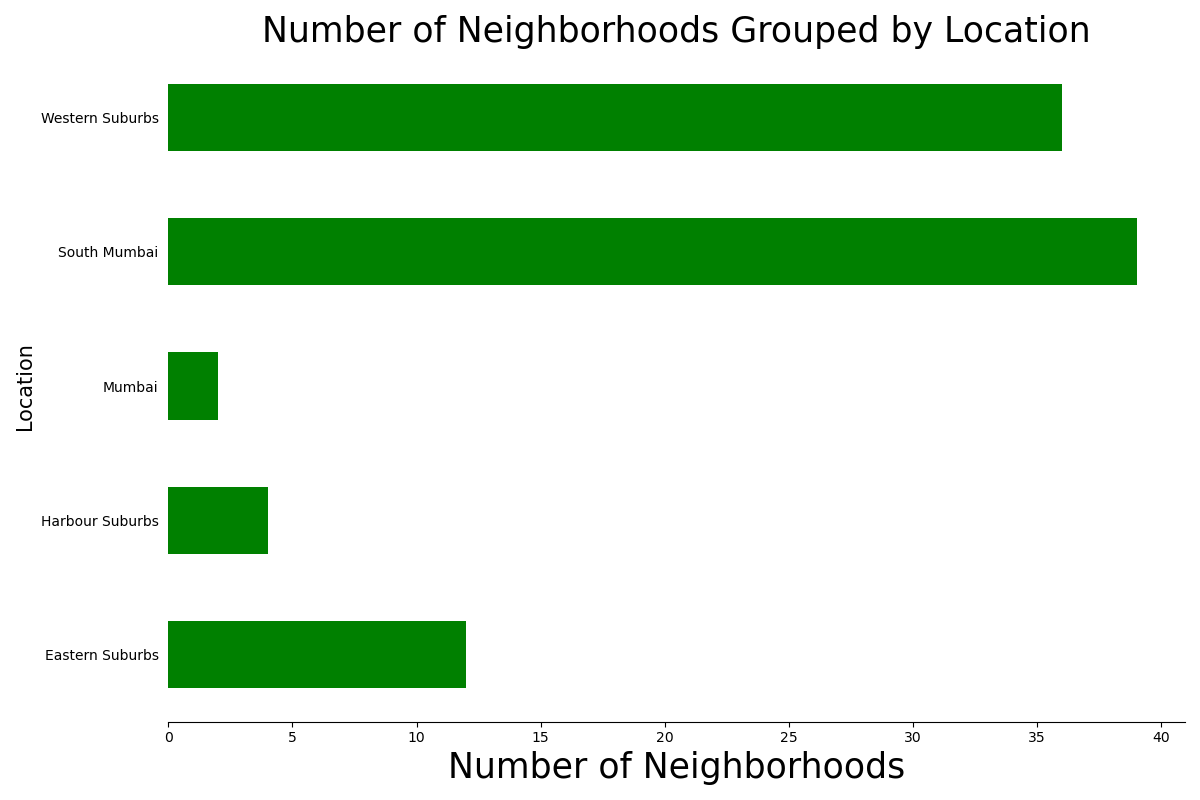

In [92]:
fig = plt.figure(figsize=(12,8))

ax = neighborhoods_mumbai.plot(kind='barh', color='green')
ax.set_title('Number of Neighborhoods Grouped by Location', fontsize=25)
ax.set_xlabel('Number of Neighborhoods', fontsize=25)
ax.set_ylabel('Location', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)

fig.tight_layout()

### FOLIUM MAPPING

In [40]:
map_mum = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

### THE FOURSQUARE API FOR RECOMMENDATIONS

In [41]:
neighborhood_name = df.loc[0, 'Neighborhood']
neighborhood_lat = df.loc[0, 'Latitude']
neighborhood_long = df.loc[0, 'Longitude']

print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The neighborhood is Amboli and it's geographical coordinates are 19.1293 latitude and 72.84644000000003 longitude


In [42]:
# define Foursquare Credentials and Version
CLIENT_ID = 'CPW3BYE0AHWLF5PWGTPDWEZEZOQ5GA2KL4DMBUSUW04HQGC2' # your Foursquare ID
CLIENT_SECRET = 'IEQ2HT4AE3AA4P1WQQMGB0HVK15JSI5S333CJUUUL3YCL0SJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CPW3BYE0AHWLF5PWGTPDWEZEZOQ5GA2KL4DMBUSUW04HQGC2
CLIENT_SECRET:IEQ2HT4AE3AA4P1WQQMGB0HVK15JSI5S333CJUUUL3YCL0SJ


In [43]:
LIMIT = 200
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

In [44]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60bf3c53d4d9b915dfb94a50'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Jogeshwari West',
  'headerFullLocation': 'Jogeshwari West, Mumbai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 26,
  'suggestedBounds': {'ne': {'lat': 19.13830000900001,
    'lng': 72.85594823590122},
   'sw': {'lat': 19.120299990999992, 'lng': 72.83693176409884}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e4eb3c68877402b06b92160',
       'name': '5 Spice , Bandra',
       'location': {'address': 'Pali Naka, Bandra west',
        'lat': 19.130421080343595,
        'lng': 72.84720633881638,
        'labeledLatLngs': [{'label': 'display',
    

### EXTRACTING VENUES

In [45]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [46]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206
1,Cafe Arfa,Indian Restaurant,19.128930,72.847140
2,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant,19.137714,72.845909
3,Narayan Sandwich,Sandwich Place,19.121398,72.850270
4,Domino's Pizza,Pizza Place,19.131000,72.848000


In [47]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

26 venues were returned for Amboli by Foursquare


In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [49]:
mum_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius)

Amboli
Chakala, Andheri
D.N. Nagar
Four Bungalows
Lokhandwala
Marol
Sahar
Seven Bungalows
Versova
Mira Road
Bhayandar
Uttan
Bandstand Promenade
Kherwadi
Pali Hill
I.C. Colony
Gorai
Dahisar
Aarey Milk Colony
Bangur Nagar
Jogeshwari West
Juhu
Charkop
Poisar
Mahavir Nagar
Thakur village
Pali Naka
Khar Danda
Dindoshi
Sunder Nagar
Kalina
Naigaon
Nalasopara
Virar
Irla
Vile Parle
Bhandup
Amrut Nagar
Asalfa
Pant Nagar
Kanjurmarg
Nehru Nagar
Nahur
Chandivali
Hiranandani Gardens
Indian Institute of Technology Bombay campus
Vidyavihar
Vikhroli
Chembur
Deonar
Mankhurd
Mahul
Agripada
Altamount Road
Bhuleshwar
Breach Candy
Carmichael Road
Cavel
Churchgate
Cotton Green
Cuffe Parade
Cumbala Hill
Currey Road
Dhobitalao
Dongri
Kala Ghoda
Kemps Corner
Lower Parel
Mahalaxmi
Mahim
Malabar Hill
Marine Drive
Marine Lines
Mumbai Central
Nariman Point
Prabhadevi
Sion
Walkeshwar
Worli
C.G.S. colony
Dagdi Chawl
Navy Nagar
Hindu colony
Ballard Estate
Chira Bazaar
Fanas Wadi
Chor Bazaar
Matunga
Parel
Gowalia Tank


In [50]:
print(mum_venues.shape)
mum_venues.head(10)

(3192, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.1293,72.84644,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
1,Amboli,19.1293,72.84644,Cafe Arfa,19.128930,72.847140,Indian Restaurant
2,Amboli,19.1293,72.84644,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Mughlai Restaurant
3,Amboli,19.1293,72.84644,Narayan Sandwich,19.121398,72.850270,Sandwich Place
4,Amboli,19.1293,72.84644,Domino's Pizza,19.131000,72.848000,Pizza Place
5,Amboli,19.1293,72.84644,Persia Darbar,19.136952,72.846822,Indian Restaurant
6,Amboli,19.1293,72.84644,Garden Court,19.127188,72.837478,Indian Restaurant
7,Amboli,19.1293,72.84644,Subway,19.127860,72.844461,Sandwich Place
8,Amboli,19.1293,72.84644,Courtyard Restaurant & Bar,19.131692,72.837269,Asian Restaurant
9,Amboli,19.1293,72.84644,Kamal Chhaya Bar,19.128245,72.837610,Bar


In [51]:
mum_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aarey Milk Colony,16,16,16,16,16,16
1,Agripada,26,26,26,26,26,26
2,Altamount Road,62,62,62,62,62,62
3,Amboli,26,26,26,26,26,26
4,Amrut Nagar,13,13,13,13,13,13
...,...,...,...,...,...,...,...
88,Vikhroli,8,8,8,8,8,8
89,Vile Parle,63,63,63,63,63,63
90,Virar,14,14,14,14,14,14
91,Walkeshwar,9,9,9,9,9,9


In [52]:
print("There are {} unique categories".format(mum_venues['Venue Category'].nunique()))

There are 208 unique categories


### NEIGHBORHOODS ON ANALISYS

In [53]:
mum_onehot = pd.get_dummies(mum_venues[['Venue Category']], prefix="", prefix_sep="")
mum_onehot.head()

,Accessories Store,Advertising Agency,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,...,Train,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
mum_onehot['Neighborhood'] = mum_venues['Neighborhood']
mum_onehot.head()

,Accessories Store,Advertising Agency,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,...,Train,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
temp = list(mum_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
mum_onehot = mum_onehot[fixed_columns]

mum_onehot.head()

,Neighborhood,Accessories Store,Advertising Agency,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,...,Train,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
mum_grouped = mum_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(mum_grouped.shape)
mum_grouped.head(10)

(93, 208)


,Neighborhood,Accessories Store,Advertising Agency,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,...,Train,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Amboli,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,"Chakala, Andheri",0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.064516,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,D.N. Nagar,0.024390,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02439,0.048780,0.0,0.0,0.0,0.0,0.024390,0.0,0.0
3,Four Bungalows,0.019231,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.038462,0.0,0.0,0.0,0.0,0.019231,0.0,0.0
4,Lokhandwala,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.012658,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,Marol,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,Sahar,0.000000,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,Seven Bungalows,0.018868,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.037736,0.0,0.0,0.0,0.0,0.018868,0.0,0.0
8,Versova,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,Mira Road,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [57]:
num_top_venues = 5

for hood in mum_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mum_grouped[mum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amboli----
               venue  freq
0  Indian Restaurant  0.12
1     Sandwich Place  0.08
2        Pizza Place  0.08
3        Coffee Shop  0.08
4                Bar  0.08


----Chakala, Andheri----
               venue  freq
0  Indian Restaurant  0.19
1              Hotel  0.19
2               Café  0.10
3         Restaurant  0.06
4   Asian Restaurant  0.06


----D.N. Nagar----
                           venue  freq
0                            Bar  0.10
1                            Pub  0.10
2              Indian Restaurant  0.10
3                    Pizza Place  0.07
4  Vegetarian / Vegan Restaurant  0.05


----Four Bungalows----
                           venue  freq
0                            Pub  0.08
1             Chinese Restaurant  0.08
2              Indian Restaurant  0.06
3             Seafood Restaurant  0.06
4  Vegetarian / Vegan Restaurant  0.04


----Lokhandwala----
                  venue  freq
0     Indian Restaurant  0.11
1                  Café  0.10
2       

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_grouped['Neighborhood']

for ind in np.arange(mum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Indian Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Bar,Burger Joint,Metro Station,Snack Place,Bus Station,Food & Drink Shop
1,"Chakala, Andheri",Hotel,Indian Restaurant,Café,Asian Restaurant,Gym,Vegetarian / Vegan Restaurant,Pizza Place,Restaurant,Hotel Bar,Fast Food Restaurant
2,D.N. Nagar,Bar,Indian Restaurant,Pub,Pizza Place,Coffee Shop,Snack Place,Lounge,Vegetarian / Vegan Restaurant,Sandwich Place,Burger Joint
3,Four Bungalows,Chinese Restaurant,Pub,Seafood Restaurant,Indian Restaurant,Café,Pizza Place,Lounge,Cocktail Bar,Vegetarian / Vegan Restaurant,Ice Cream Shop
4,Lokhandwala,Indian Restaurant,Café,Chinese Restaurant,Coffee Shop,Pub,Bar,Fast Food Restaurant,Seafood Restaurant,Bengali Restaurant,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...
88,Parel,Indian Restaurant,Coffee Shop,Plaza,Restaurant,Rest Area,Bar,Maharashtrian Restaurant,Chinese Restaurant,Sporting Goods Shop,Bus Station
89,Gowalia Tank,Indian Restaurant,Bakery,Fast Food Restaurant,Coffee Shop,Café,Sandwich Place,Snack Place,Food Truck,Pizza Place,Electronics Store
90,Dava Bazaar,Train Station,Asian Restaurant,Café,Fish Market,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Clothing Store,Fish & Chips Shop,Film Studio
91,Dharavi,Indian Restaurant,Juice Bar,Music Venue,Fast Food Restaurant,Shoe Store,Seafood Restaurant,Sandwich Place,Luggage Store,Lake,Café


### CLUSTERING PROCESS

In [60]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [61]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = mum_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

[0.07195619506977537, 0.3331694601197973, 0.07920052222867548, 0.08006891795116575, 0.08721505077773907, 0.08269622044285427, 0.04484369098118108, 0.0781411936749771, 0.07423117469011704, 0.0738289438154623, 0.07178543691690802, 0.04339423531263244, 0.047887758749703024, 0.056959168341623095]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<IPython.core.display.Javascript object>


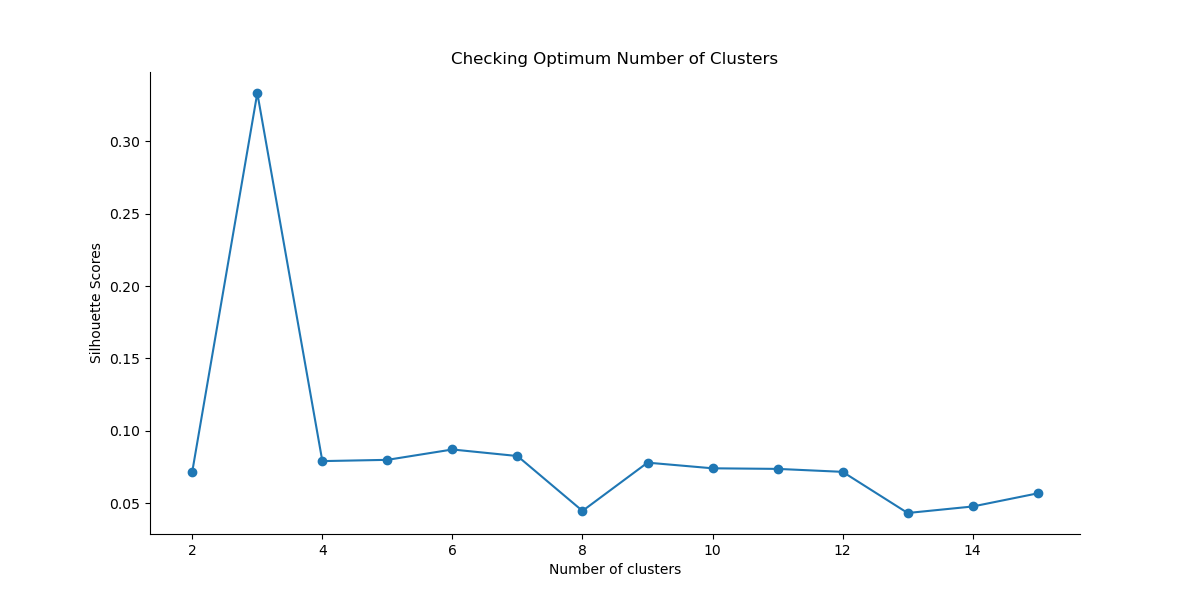

In [62]:
print(scores)
print(kval)
plot(kval, scores)

In [63]:
k = 5

mum_clustering = mum_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(mum_clustering) #Can choose any random_state

kmeans.labels_

array([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 2, 1, 4], dtype=int32)

In [64]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
mum_merged = df
mum_merged = mum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [65]:
print(mum_merged.shape)
mum_merged

(93, 15)


,Neighborhood,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,19.1293,72.8464,1,Indian Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Bar,Burger Joint,Metro Station,Snack Place,Bus Station,Food & Drink Shop
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,0,Hotel,Indian Restaurant,Café,Asian Restaurant,Gym,Vegetarian / Vegan Restaurant,Pizza Place,Restaurant,Hotel Bar,Fast Food Restaurant
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,1,Bar,Indian Restaurant,Pub,Pizza Place,Coffee Shop,Snack Place,Lounge,Vegetarian / Vegan Restaurant,Sandwich Place,Burger Joint
3,Four Bungalows,Western Suburbs,19.1264,72.8242,1,Chinese Restaurant,Pub,Seafood Restaurant,Indian Restaurant,Café,Pizza Place,Lounge,Cocktail Bar,Vegetarian / Vegan Restaurant,Ice Cream Shop
4,Lokhandwala,Western Suburbs,19.1432,72.8249,1,Indian Restaurant,Café,Chinese Restaurant,Coffee Shop,Pub,Bar,Fast Food Restaurant,Seafood Restaurant,Bengali Restaurant,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Parel,South Mumbai,18.9957,72.84,0,Indian Restaurant,Coffee Shop,Plaza,Restaurant,Rest Area,Bar,Maharashtrian Restaurant,Chinese Restaurant,Sporting Goods Shop,Bus Station
89,Gowalia Tank,South Mumbai,18.9645,72.8112,1,Indian Restaurant,Bakery,Fast Food Restaurant,Coffee Shop,Café,Sandwich Place,Snack Place,Food Truck,Pizza Place,Electronics Store
90,Dava Bazaar,South Mumbai,19.1314,72.927,2,Train Station,Asian Restaurant,Café,Fish Market,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Clothing Store,Fish & Chips Shop,Film Studio
91,Dharavi,Mumbai,19.0467,72.8546,1,Indian Restaurant,Juice Bar,Music Venue,Fast Food Restaurant,Shoe Store,Seafood Restaurant,Sandwich Place,Luggage Store,Lake,Café


In [66]:
mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Chakala, Andheri",Western Suburbs,Hotel,Indian Restaurant,Café,Asian Restaurant,Gym,Vegetarian / Vegan Restaurant,Pizza Place,Restaurant,Hotel Bar,Fast Food Restaurant
5,Marol,Western Suburbs,Indian Restaurant,Chinese Restaurant,Hotel,Lounge,Coffee Shop,Restaurant,Diner,Farmers Market,Fast Food Restaurant,Flea Market
6,Sahar,Western Suburbs,Hotel,Indian Restaurant,Asian Restaurant,Italian Restaurant,Café,Coffee Shop,Restaurant,Airport Lounge,Field,Electronics Store
9,Mira Road,Western Suburbs,Indian Restaurant,Sporting Goods Shop,Mexican Restaurant,Restaurant,Fast Food Restaurant,Coffee Shop,Multiplex,Movie Theater,Basketball Court,Bar
20,Jogeshwari West,Western Suburbs,Indian Restaurant,Food & Drink Shop,Dessert Shop,Pharmacy,Mughlai Restaurant,Steakhouse,Café,Athletics & Sports,Chinese Restaurant,Ice Cream Shop
29,Sunder Nagar,Western Suburbs,Indian Restaurant,Coffee Shop,Movie Theater,Café,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Train Station,Restaurant,Bakery,Breakfast Spot
30,Kalina,Western Suburbs,Indian Restaurant,Lounge,Juice Bar,Bar,Pizza Place,Grocery Store,Ice Cream Shop,Vegetarian / Vegan Restaurant,Chinese Restaurant,Fast Food Restaurant
34,Irla,Western Suburbs,Coffee Shop,Indian Restaurant,Chinese Restaurant,Café,Bakery,Flea Market,Theater,Pizza Place,Dessert Shop,Clothing Store
35,Vile Parle,Western Suburbs,Indian Restaurant,Coffee Shop,Café,Sandwich Place,Hotel,Bar,Cocktail Bar,Gym,Snack Place,Tea Room
37,Amrut Nagar,Eastern Suburbs,Indian Restaurant,Ice Cream Shop,Café,Flea Market,Pharmacy,Plaza,Multiplex,Train Station,Mughlai Restaurant,Dessert Shop


In [67]:
mum_merged.loc[mum_merged['Cluster Labels'] == 1, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,Indian Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Bar,Burger Joint,Metro Station,Snack Place,Bus Station,Food & Drink Shop
2,D.N. Nagar,Western Suburbs,Bar,Indian Restaurant,Pub,Pizza Place,Coffee Shop,Snack Place,Lounge,Vegetarian / Vegan Restaurant,Sandwich Place,Burger Joint
3,Four Bungalows,Western Suburbs,Chinese Restaurant,Pub,Seafood Restaurant,Indian Restaurant,Café,Pizza Place,Lounge,Cocktail Bar,Vegetarian / Vegan Restaurant,Ice Cream Shop
4,Lokhandwala,Western Suburbs,Indian Restaurant,Café,Chinese Restaurant,Coffee Shop,Pub,Bar,Fast Food Restaurant,Seafood Restaurant,Bengali Restaurant,Pizza Place
7,Seven Bungalows,Western Suburbs,Bar,Café,Pub,Chinese Restaurant,Pizza Place,Seafood Restaurant,Coffee Shop,Lounge,Vegetarian / Vegan Restaurant,Ice Cream Shop
8,Versova,Western Suburbs,Café,Ice Cream Shop,Beach,Coffee Shop,Chinese Restaurant,Restaurant,Bistro,Bookstore,Miscellaneous Shop,Film Studio
10,Bhayandar,Western Suburbs,Ice Cream Shop,Indian Restaurant,Pizza Place,Food Truck,Train Station,Bakery,Diner,Zoo,Electronics Store,Fish & Chips Shop
12,Bandstand Promenade,Western Suburbs,Coffee Shop,Café,Tea Room,Performing Arts Venue,Deli / Bodega,Indian Restaurant,Scenic Lookout,Fast Food Restaurant,Food Truck,Beach
13,Kherwadi,Western Suburbs,Indian Restaurant,Café,Bar,Hookah Bar,Restaurant,Italian Restaurant,Multiplex,Chinese Restaurant,Seafood Restaurant,Asian Restaurant
14,Pali Hill,Western Suburbs,Indian Restaurant,Fast Food Restaurant,Dessert Shop,Bakery,Café,Asian Restaurant,Bar,Cupcake Shop,Seafood Restaurant,Ice Cream Shop


In [68]:
mum_merged.loc[mum_merged['Cluster Labels'] == 2, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Bhandup,Eastern Suburbs,Train Station,Asian Restaurant,Indian Restaurant,Fast Food Restaurant,Diner,Flea Market,Fish Market,Fish & Chips Shop,Film Studio,Field
40,Kanjurmarg,Eastern Suburbs,Train Station,Asian Restaurant,Gym,Multiplex,Gift Shop,Chinese Restaurant,Diner,Fish & Chips Shop,Film Studio,Field
50,Mankhurd,Harbour Suburbs,Coffee Shop,Sports Bar,Train Station,Bus Station,Zoo,Donut Shop,Fish Market,Fish & Chips Shop,Film Studio,Field
90,Dava Bazaar,South Mumbai,Train Station,Asian Restaurant,Café,Fish Market,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Clothing Store,Fish & Chips Shop,Film Studio


In [69]:
mum_merged.loc[mum_merged['Cluster Labels'] == 3, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Uttan,Western Suburbs,Convenience Store,Indian Restaurant,Whisky Bar,Restaurant,Diner,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant


In [70]:
mum_merged.loc[mum_merged['Cluster Labels'] == 4, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,Thane,Mumbai,Pizza Place,Performing Arts Venue,Zoo,Diner,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market


In [71]:
new_restaurant_neighborhoods = mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0, 1, 2, 3] + list(range(5, mum_merged.shape[1]))]]
new_restaurant_neighborhoods.head()

,Neighborhood,Location,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,Hotel,Indian Restaurant,Café,Asian Restaurant,Gym,Vegetarian / Vegan Restaurant,Pizza Place,Restaurant,Hotel Bar,Fast Food Restaurant
5,Marol,Western Suburbs,19.1192,72.8827,Indian Restaurant,Chinese Restaurant,Hotel,Lounge,Coffee Shop,Restaurant,Diner,Farmers Market,Fast Food Restaurant,Flea Market
6,Sahar,Western Suburbs,19.1027,72.8626,Hotel,Indian Restaurant,Asian Restaurant,Italian Restaurant,Café,Coffee Shop,Restaurant,Airport Lounge,Field,Electronics Store
9,Mira Road,Western Suburbs,19.2656,72.8711,Indian Restaurant,Sporting Goods Shop,Mexican Restaurant,Restaurant,Fast Food Restaurant,Coffee Shop,Multiplex,Movie Theater,Basketball Court,Bar
20,Jogeshwari West,Western Suburbs,19.1412,72.8433,Indian Restaurant,Food & Drink Shop,Dessert Shop,Pharmacy,Mughlai Restaurant,Steakhouse,Café,Athletics & Sports,Chinese Restaurant,Ice Cream Shop


In [74]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(new_restaurant_neighborhoods['Latitude'], new_restaurant_neighborhoods['Longitude'],
                                            new_restaurant_neighborhoods['Location'], new_restaurant_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightblue'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations